In [6]:
# we set a counter to register the same dataset again under a different name when we are debugging
global regis_num 
regis_num = 0

In [2]:
!pip install pyyaml==5.1
#!pip uninstall torch
!yes | pip uninstall detectron2
#!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
    
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html

Found existing installation: detectron2 0.6+cu111
Uninstalling detectron2-0.6+cu111:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/detectron2-0.6+cu111.dist-info/*
    /usr/local/lib/python3.8/dist-packages/detectron2/*
    /usr/local/lib/python3.8/dist-packages/tools/*
Proceed (Y/n)?   Successfully uninstalled detectron2-0.6+cu111
yes: standard output: Broken pipe
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
  Using cached https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/detectron2-0.6%2Bcu111-cp38-cp38-linux_x86_64.whl (6.9 MB)


In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.9 ; cuda:  cu111
detectron2: 0.6


In [3]:
from pathlib import Path
import os
import sys

In [3]:
base = Path.cwd() / "workspace" / "scripts" 

In [18]:
# register our datasets
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog


dataset_name_train = "thesis_sample030_train"
dataset_name_val = "thesis_sample030_val"

def register(name, path_labels, path_data):

    # Check if dataset name already exists in catalog
    if name in DatasetCatalog.list():
        # Remove existing dataset from catalog
        DatasetCatalog.remove(name)
        MetadataCatalog.remove(name)

    # Register your dataset using register_coco_instances
    register_coco_instances(name, {}, path_labels, path_data)

# if it throws an error that name is already registered, just change the name... 
register(dataset_name_train, "/workspace/data/data_small_sample/data_sample_030/train/labels_train.json", "/workspace/data/data_small_sample/data_sample_030/train/data")
register(dataset_name_val, "/workspace/data/data_small_sample/data_sample_030/val/labels_val.json", "/workspace/data/data_small_sample/data_sample_030/val/data")


In [19]:
dataset_name_train

'thesis_sample030_train'

In [9]:
import json

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data import build_detection_train_loader
from detectron2.data import DatasetMapper
from detectron2.data import DatasetCatalog

class OurTrainer(DefaultTrainer):

    def __init__(self, cfg):
        super().__init__(cfg)

        if isinstance(cfg.DATASETS.EVAL, str):
            self.eval_datasets = [cfg.DATASETS.EVAL]
        else:
            self.eval_datasets = cfg.DATASETS.EVAL

        # prepare evaluation
        self.eval_loaders = []
        self.evaluators = []
        for dataset in self.eval_datasets:

            loader = build_detection_test_loader(DatasetCatalog.get(dataset), 
                                                 mapper=DatasetMapper(cfg, is_train=False))

            self.eval_loaders.append(loader)
            self.evaluators.append(COCOEvaluator(
                dataset,
                output_dir=cfg.OUTPUT_DIR 
                ))
    
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg)
    
    #    if cfg.SOLVER.STRONG_AUGMENT:
    #       print("STRONG AUGMENTATIONS TO TRAINING SET")
    #        return build_detection_train_loader(cfg, mapper=DatasetMapperAugment(cfg, is_train=True)) 
    #    else:
    #        return build_detection_train_loader(cfg)

    
    def after_step(self):
        super().after_step()

        if (self.iter+1) % self.cfg.TEST.INTERVAL == 0:                                   
    
            for dataset, loader, evaluator in zip(self.eval_datasets, 
                                                    self.eval_loaders,
                                                    self.evaluators):
    
                results = inference_on_dataset(self.model,
                                                loader,
                                                evaluator)
                with open(
                    os.path.join(
                        self.cfg.OUTPUT_DIR,
                        'eval_'+dataset+'_iter_'+str(self.iter)+'.json'),
                        'w') as out:
                    json.dump(results, out)
    

In [10]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [20]:
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

cfg.OUTPUT_DIR = "/workspace/output_sample030_data"

In [21]:
print(f"FIND EXPERIMENT RESULTS AT \n {cfg.OUTPUT_DIR}")
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

FIND EXPERIMENT RESULTS AT 
 /workspace/output_sample030_data


In [22]:
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[4, 8, 16, 32, 64]]
cfg.SOLVER.MAX_ITER = 3000
cfg.TEST.INTERVAL = 400
cfg.SOLVER.STEPS = (2000, 2500)
cfg.SOLVER.IMS_PER_BATCH = 8

In [23]:
cfg.DATASETS.TRAIN = (dataset_name_train)
cfg.DATASETS.EVAL = [dataset_name_val]
cfg.DATASETS.TEST = []

In [ ]:
trainer = OurTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

os.rename(cfg.OUTPUT_DIR, cfg.OUTPUT_DIR + "_" + cfg.DATASETS.TRAIN + cfg.DATASETS.EVAL[-1])

[03/24 10:51:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

WARNING [03/24 10:51:18 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/24 10:51:18 d2.data.datasets.coco]: Loaded 3927 images in COCO format from /workspace/data/data_small_sample/data_sample_030/train/labels_train.json
[03/24 10:51:18 d2.data.build]: Removed 0 images with no usable annotations. 3927 images left.
[03/24 10:51:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[03/24 10:51:19 d2.data.build]: Using training sampler TrainingSampler
[03/24 10:51:19 d2.data.common]: Serializing 3927 elements to byte tensors and concatenating them all ...
[03/24 10:51:19 d2.data.common]: Serialized dataset takes 1.49 MiB
WARNING [03/24 10:51:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/24 10:51:19 d2.d

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}
  stem.conv1.bias


[03/24 10:51:19 d2.engine.train_loop]: Starting training from iteration 0
[03/24 10:51:27 d2.utils.events]:  eta: 0:18:36  iter: 19  total_loss: 0.9216  loss_cls: 0.08979  loss_box_reg: 0.002404  loss_rpn_cls: 0.6811  loss_rpn_loc: 0.09353  time: 0.3691  data_time: 0.0237  lr: 0.00039962  max_mem: 5393M
[03/24 10:51:34 d2.utils.events]:  eta: 0:18:32  iter: 39  total_loss: 0.8322  loss_cls: 0.1031  loss_box_reg: 0.005547  loss_rpn_cls: 0.5949  loss_rpn_loc: 0.08048  time: 0.3708  data_time: 0.0106  lr: 0.00079922  max_mem: 5393M
[03/24 10:51:42 d2.utils.events]:  eta: 0:18:30  iter: 59  total_loss: 0.6166  loss_cls: 0.0767  loss_box_reg: 0.008098  loss_rpn_cls: 0.4207  loss_rpn_loc: 0.1264  time: 0.3754  data_time: 0.0110  lr: 0.0011988  max_mem: 5393M
[03/24 10:51:50 d2.utils.events]:  eta: 0:18:28  iter: 79  total_loss: 0.4763  loss_cls: 0.04576  loss_box_reg: 0.01012  loss_rpn_cls: 0.2823  loss_rpn_loc: 0.1171  time: 0.3786  data_time: 0.0116  lr: 0.0015984  max_mem: 5393M
[03/24 10

[03/24 10:55:33 d2.evaluation.evaluator]: Inference done 1412/1878. Dataloading: 0.0211 s/iter. Inference: 0.0504 s/iter. Eval: 0.0002 s/iter. Total: 0.0718 s/iter. ETA=0:00:33
[03/24 10:55:38 d2.evaluation.evaluator]: Inference done 1483/1878. Dataloading: 0.0211 s/iter. Inference: 0.0504 s/iter. Eval: 0.0002 s/iter. Total: 0.0717 s/iter. ETA=0:00:28
[03/24 10:55:43 d2.evaluation.evaluator]: Inference done 1554/1878. Dataloading: 0.0211 s/iter. Inference: 0.0504 s/iter. Eval: 0.0002 s/iter. Total: 0.0717 s/iter. ETA=0:00:23
[03/24 10:55:48 d2.evaluation.evaluator]: Inference done 1625/1878. Dataloading: 0.0211 s/iter. Inference: 0.0504 s/iter. Eval: 0.0002 s/iter. Total: 0.0717 s/iter. ETA=0:00:18
[03/24 10:55:53 d2.evaluation.evaluator]: Inference done 1695/1878. Dataloading: 0.0211 s/iter. Inference: 0.0504 s/iter. Eval: 0.0002 s/iter. Total: 0.0717 s/iter. ETA=0:00:13
[03/24 10:55:58 d2.evaluation.evaluator]: Inference done 1765/1878. Dataloading: 0.0211 s/iter. Inference: 0.0504 s

[03/24 10:58:42 d2.evaluation.evaluator]: Inference done 11/1878. Dataloading: 0.0177 s/iter. Inference: 0.0464 s/iter. Eval: 0.0002 s/iter. Total: 0.0642 s/iter. ETA=0:01:59
[03/24 10:58:47 d2.evaluation.evaluator]: Inference done 82/1878. Dataloading: 0.0212 s/iter. Inference: 0.0489 s/iter. Eval: 0.0002 s/iter. Total: 0.0703 s/iter. ETA=0:02:06
[03/24 10:58:52 d2.evaluation.evaluator]: Inference done 152/1878. Dataloading: 0.0213 s/iter. Inference: 0.0497 s/iter. Eval: 0.0002 s/iter. Total: 0.0712 s/iter. ETA=0:02:02
[03/24 10:58:57 d2.evaluation.evaluator]: Inference done 222/1878. Dataloading: 0.0212 s/iter. Inference: 0.0500 s/iter. Eval: 0.0002 s/iter. Total: 0.0714 s/iter. ETA=0:01:58
[03/24 10:59:02 d2.evaluation.evaluator]: Inference done 290/1878. Dataloading: 0.0212 s/iter. Inference: 0.0507 s/iter. Eval: 0.0002 s/iter. Total: 0.0721 s/iter. ETA=0:01:54
[03/24 10:59:07 d2.evaluation.evaluator]: Inference done 360/1878. Dataloading: 0.0213 s/iter. Inference: 0.0507 s/iter. E

[03/24 11:01:42 d2.utils.events]:  eta: 0:13:25  iter: 919  total_loss: 0.6257  loss_cls: 0.2037  loss_box_reg: 0.198  loss_rpn_cls: 0.04834  loss_rpn_loc: 0.1091  time: 0.3817  data_time: 0.0114  lr: 0.018382  max_mem: 5393M
[03/24 11:01:50 d2.utils.events]:  eta: 0:13:17  iter: 939  total_loss: 0.7117  loss_cls: 0.2371  loss_box_reg: 0.2728  loss_rpn_cls: 0.04728  loss_rpn_loc: 0.1394  time: 0.3816  data_time: 0.0112  lr: 0.018781  max_mem: 5393M
[03/24 11:01:58 d2.utils.events]:  eta: 0:13:09  iter: 959  total_loss: 0.5688  loss_cls: 0.2119  loss_box_reg: 0.2147  loss_rpn_cls: 0.06885  loss_rpn_loc: 0.07263  time: 0.3817  data_time: 0.0121  lr: 0.019181  max_mem: 5393M
[03/24 11:02:05 d2.utils.events]:  eta: 0:13:02  iter: 979  total_loss: 0.6661  loss_cls: 0.2321  loss_box_reg: 0.2694  loss_rpn_cls: 0.05543  loss_rpn_loc: 0.1155  time: 0.3818  data_time: 0.0114  lr: 0.01958  max_mem: 5393M
[03/24 11:02:13 d2.utils.events]:  eta: 0:12:54  iter: 999  total_loss: 0.6384  loss_cls: 0.2

[03/24 11:05:44 d2.evaluation.evaluator]: Total inference time: 0:02:14.135489 (0.071615 s / iter per device, on 1 devices)
[03/24 11:05:44 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:34 (0.050406 s / iter per device, on 1 devices)
[03/24 11:05:44 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/24 11:05:44 d2.evaluation.coco_evaluation]: Saving results to /workspace/output_sample030_data/coco_instances_results.json
[03/24 11:05:44 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.21s)
creating index...
index created!
[03/24 11:05:45 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[03/24 11:05:45 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.30 seconds.
[03/24 11:05:45 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[03/24 11:05:45 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.09 seconds.


[03/24 11:08:59 d2.evaluation.evaluator]: Inference done 574/1878. Dataloading: 0.0211 s/iter. Inference: 0.0501 s/iter. Eval: 0.0001 s/iter. Total: 0.0714 s/iter. ETA=0:01:33
[03/24 11:09:04 d2.evaluation.evaluator]: Inference done 645/1878. Dataloading: 0.0211 s/iter. Inference: 0.0502 s/iter. Eval: 0.0001 s/iter. Total: 0.0714 s/iter. ETA=0:01:28
[03/24 11:09:09 d2.evaluation.evaluator]: Inference done 715/1878. Dataloading: 0.0211 s/iter. Inference: 0.0502 s/iter. Eval: 0.0001 s/iter. Total: 0.0715 s/iter. ETA=0:01:23
[03/24 11:09:14 d2.evaluation.evaluator]: Inference done 786/1878. Dataloading: 0.0211 s/iter. Inference: 0.0502 s/iter. Eval: 0.0001 s/iter. Total: 0.0715 s/iter. ETA=0:01:18
[03/24 11:09:19 d2.evaluation.evaluator]: Inference done 856/1878. Dataloading: 0.0211 s/iter. Inference: 0.0502 s/iter. Eval: 0.0001 s/iter. Total: 0.0715 s/iter. ETA=0:01:13
[03/24 11:09:24 d2.evaluation.evaluator]: Inference done 926/1878. Dataloading: 0.0211 s/iter. Inference: 0.0502 s/iter.

In [2]:
# some inference

In [15]:
#os.rename(cfg.OUTPUT_DIR, cfg.OUTPUT_DIR + "_" + cfg.DATASETS.TRAIN + cfg.DATASETS.EVAL[-1])
cfg.OUTPUT_DIR = "/workspace/output_thesis_samplethesis_sample"

In [17]:
from detectron2.engine import DefaultPredictor

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.weight' to the model due to incompatible shapes: (15, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.bias' to the model due to incompatible shapes: (15,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.anchor_deltas.weight' to the model due to incompatible shapes: (60, 256, 1, 1) in the checkpoint but (12, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.anchor_deltas.bias' to the model due to incompatible shapes: (60,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
proposal_generator.rpn_head.anch


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size,

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.

In [10]:
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

In [11]:
cfg = get_cfg()

In [12]:
from pprint import pprint

In [13]:
pprint(cfg)

{'CUDNN_BENCHMARK': False,
 'DATALOADER': {'ASPECT_RATIO_GROUPING': True,
                'FILTER_EMPTY_ANNOTATIONS': True,
                'NUM_WORKERS': 4,
                'REPEAT_THRESHOLD': 0.0,
                'SAMPLER_TRAIN': 'TrainingSampler'},
 'DATASETS': {'PRECOMPUTED_PROPOSAL_TOPK_TEST': 1000,
              'PRECOMPUTED_PROPOSAL_TOPK_TRAIN': 2000,
              'PROPOSAL_FILES_TEST': (),
              'PROPOSAL_FILES_TRAIN': (),
              'TEST': ('coco_2017_val',),
              'TRAIN': ('coco_2017_train',)},
 'GLOBAL': CfgNode({'HACK': 1.0}),
 'INPUT': {'CROP': {'ENABLED': False,
                    'SIZE': [0.9, 0.9],
                    'TYPE': 'relative_range'},
           'FORMAT': 'BGR',
           'MASK_FORMAT': 'polygon',
           'MAX_SIZE_TEST': 1333,
           'MAX_SIZE_TRAIN': 1333,
           'MIN_SIZE_TEST': 800,
           'MIN_SIZE_TRAIN': (640, 672, 704, 736, 768, 800),
           'MIN_SIZE_TRAIN_SAMPLING': 'choice',
           'RANDOM_FLIP': 'horiz

In [2]:
!yes | sudo apt install python3.8-venv

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3.8-venv is already the newest version (3.8.10-0ubuntu1~20.04.6).
0 upgraded, 0 newly installed, 0 to remove and 58 not upgraded.
yes: standard output: Broken pipe


In [3]:
#!source env_thesis/bin/activate

In [4]:
!sudo apt-get install gcc g\+\+

Reading package lists... Done
Building dependency tree       
Reading state information... Done
g++ is already the newest version (4:9.3.0-1ubuntu2).
gcc is already the newest version (4:9.3.0-1ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 58 not upgraded.


In [5]:
!pip uninstall detectron2

In [6]:
#johannes try
#!pip install torch==1.10.1 torchvision==0.11.2 torchaudio==0.10.1

In [7]:
# dinah try
!pip3 install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [8]:
# use to remove old detectron installations
!rm -r detectron2

In [9]:
!pip3 install ninja

In [20]:
!python3 -m pip install setuptools==58.2.0

  Using cached setuptools-58.2.0-py3-none-any.whl (946 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.6.0
    Uninstalling setuptools-67.6.0:
      Successfully uninstalled setuptools-67.6.0


In [11]:
#!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [12]:
#make sure detectron installation files knows where to find torch
!LD_LIBRARY_PATH=.../python3.9/site-packages/torch/lib/nvidia/cublas/lib/:$LD_LIBRARY_PATH

In [13]:
!python -m pip install pyyaml==5.3.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Cloning into 'detectron2'...
remote: Enumerating objects: 14935, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 14935 (delta 7), reused 15 (delta 7), pack-reused 14915
Receiving objects: 100% (14935/14935), 6.05 MiB | 23.13 MiB/s, done.
Resolving deltas: 100% (10829/10829), done.


In [14]:
import sys, os, distutils.core
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.9 ; cuda:  cu111


AttributeError: module 'detectron2' has no attribute '__version__'

In [12]:
!pip3 install opencv-python

In [13]:
!yes | sudo apt-get install libgl1-mesa-glx

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-glx is already the newest version (21.2.6-0ubuntu0.1~20.04.2).
0 upgraded, 0 newly installed, 0 to remove and 58 not upgraded.
yes: standard output: Broken pipe


In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os
import json
import cv2
import random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances


ModuleNotFoundError: No module named 'detectron2.utils'

In [15]:
!LD_LIBRARY_PATH=.../python3.9/site-packages/cv2/:$LD_LIBRARY_PATH

In [16]:
os.getcwd()

'/workspace/scripts'

In [17]:
#changed the data path to the newly split data with train, val, test
base_path = '/workspace/data/'

#im = cv2.imread(base_path + "data_30/data.png")

In [20]:
## CRASHT DAS KERNEL !!
#cv2.imshow("testimage", im)

## Train on our dataset

In [21]:
# we set a counter to register the same dataset again under a different name when we are debugging
global regis_num 
regis_num = 0

In [22]:
# Taken from https://eidos-ai.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
# https://gist.github.com/ortegatron/c0dad15e49c2b74de8bb09a5615d9f6b

from EvalLossHook import LossEvalHook
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data import DatasetMapper


class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            self.cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

In [27]:
def train_detectron_standard(dataset_name_train, dataset_name_val, resolution, batch_size=2):

    '''
    func:   trains a standard detectron model with the given dataset name

    inputs:
    dataset_name_train: string name of the dataset that was registered with COCODataset
    resolution:         the resolution that the images have

    returns:
    cfg:        configurations object
    trainer:    trainer object from the model
    predictor:  predictor object from the model
    '''

    cfg = get_cfg()
    # try different model: changed to X101 FPN: faster_rcnn_X_101_32x8d_FPN_3x
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.OUTPUT_DIR = f"/workspace/output/output_{resolution}_{str(batch_size)}"
    cfg.DATASETS.TRAIN = (dataset_name_train)
    cfg.DATASETS.TEST = (dataset_name_val,)
    cfg.TEST.EVAL_PERIOD = 3333
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = batch_size  # This is the real "batch size" commonly known to deep learning people
    cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR - davor
    cfg.SOLVER.MAX_ITER = 10000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
    cfg.SOLVER.STEPS = []        # do not decay learning rate
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # has two plus one classes transmission and distribution tower + other towers. (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
    # NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

    #print(cfg.OUTPUT_DIR)


    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = MyTrainer(cfg) 
    trainer.resume_or_load(resume=False)
    trainer.train()


    # Inference should use the config with parameters that are used in training
    # cfg now already contains everything we've set previously. We changed it a little bit for inference:
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3   # set a custom testing threshold
    predictor = DefaultPredictor(cfg)


    return cfg, trainer, predictor

def evaluate_detectron(cfg, predictor_obj, resolution, dataset_name_val): 

    """
    func:   evaluates a trained detectron model

    input:
    cfg:                configuration object of the model
    predictor_obj:      the predictor object of the same model 
    resolution:         the resolution of the images
    dataset_name_val:   the COCO registered name of the val dataset

    returns:            dictionary with model metrics 
    """

    evaluator = COCOEvaluator(dataset_name_val, output_dir="/workspace/output/output"+str(resolution), max_dets_per_image = 30)
    val_loader = build_detection_test_loader(cfg, dataset_name_val)
    
    return inference_on_dataset(predictor_obj.model, val_loader, evaluator)
    # another equivalent way to evaluate the model is to use `trainer.test`

In [28]:
# notes for parameters
# max_dets_per_image Anzahl zu detektierender Objekte - wir haben Bilder mit bis zu 30 Türmen
# set learning rate von 0.00025 auf 0.0025
# set training iterations von 300 auf 1000

### Experiments to conduct / TODO

- train, val, test split
- loss curves plotten
- influence of batch size 
- ROI heads verkleinern
- learning rate
- image augmentation when training in loader

In [29]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
resolution_set = ['030']#, '035','040','045','050','070','100']
batch_size = [5]

eval_objs = []
for bs in batch_size:

    res = '030'
    #define the names 
    dataset_name_train = "tower_train_" + str(res) + "1"
    dataset_name_val = "tower_val_" + str(res) + "1"

    try: 
        # if it throws an error that name is already registered, just change the name... 
        register_coco_instances(dataset_name_train, {}, "/workspace/data_unsplit/labels_train.json", base_path+"data_"+str(res)+"/train/data")
        register_coco_instances(dataset_name_val, {}, "/workspace/data_unsplit/labels_val.json", base_path+"data_"+str(res)+"/val/data")

        #MetadataCatalog.get(dataset_name_train).set(thing_classes=["distribution", "transmission"])
        #MetadataCatalog.get(dataset_name_val).set(thing_classes=["distribution", "transmission"])
    
    except: 
        regis_num += 1
        dataset_name_train += str(regis_num)
        dataset_name_val += str(regis_num)

        # if it throws an error that name is already registered, just change the name... 
        register_coco_instances(dataset_name_train, {}, "/workspace/data_unsplit/labels_train.json", base_path+"data_"+str(res)+"/train/data")
        register_coco_instances(dataset_name_val, {}, "/workspace/data_unsplit/labels_val.json", base_path+"data_"+str(res)+"/val/data")
        #MetadataCatalog.get(dataset_name_train).set(thing_classes=["distribution", "transmission"])
        #MetadataCatalog.get(dataset_name_val).set(thing_classes=["distribution", "transmission"])

    configuration, train_obj, predictor_obj = train_detectron_standard(dataset_name_train, dataset_name_val, res, batch_size = bs)

    eval_objs.append(evaluate_detectron(configuration, predictor_obj, res, dataset_name_val))

#with open('../eval.txt', 'w') as f:
#    f.write(str(eval_objs))

[03/15 15:22:40 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

WARNING [03/15 15:22:40 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/15 15:22:40 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data_unsplit/labels_train.json
[03/15 15:22:40 d2.data.build]: Removed 0 images with no usable annotations. 11696 images left.
[03/15 15:22:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[03/15 15:22:41 d2.data.build]: Using training sampler TrainingSampler
[03/15 15:22:41 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/15 15:22:41 d2.data.common]: Serializing 11696 elements to byte tensors and concatenating them all ...
[03/15 15:22:41 d2.data.common]: Serialized dataset takes 5.95 MiB
[03/15 15:22:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentation

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[03/15 15:22:41 d2.engine.train_loop]: Starting training from iteration 0
[03/15 15:22:47 d2.utils.events]:  eta: 0:46:26  iter: 19  total_loss: 2.571  loss_cls: 1.208  loss_box_reg: 0.00361  loss_rpn_cls: 1.282  loss_rpn_loc: 0.08976    time: 0.2714  last_time: 0.2815  data_time: 0.0424  last_data_time: 0.0408   lr: 4.9953e-06  max_mem: 4003M
[03/15 15:22:53 d2.utils.events]:  eta: 0:46:21  iter: 39  total_loss: 1.833  loss_cls: 1.065  loss_box_reg: 0.00567  loss_rpn_cls: 0.7155  loss_rpn_loc: 0.05349    time: 0.2736  last_time: 0.2813  data_time: 0.0358  last_data_time: 0.0318   lr: 9.9902e-06  max_mem: 4003M
[03/15 15:22:58 d2.utils.events]:  eta: 0:46:34  iter: 59  total_loss: 1.592  loss_cls: 0.8315  loss_box_reg: 0.005662  loss_rpn_cls: 0.6051  loss_rpn_loc: 0.06564    time: 0.2756  last_time: 0.2853  data_time: 0.0338  last_data_time: 0.0356   lr: 1.4985e-05  max_mem: 4003M
[03/15 15:23:04 d2.utils.events]:  eta: 0:46:31  iter: 79  total_loss: 1.293  loss_cls: 0.5815  loss_box_r

[03/15 15:25:30 d2.utils.events]:  eta: 0:43:25  iter: 619  total_loss: 0.4076  loss_cls: 0.1226  loss_box_reg: 0.07275  loss_rpn_cls: 0.1369  loss_rpn_loc: 0.06357    time: 0.2713  last_time: 0.2812  data_time: 0.0327  last_data_time: 0.0352   lr: 0.00015485  max_mem: 4003M
[03/15 15:25:35 d2.utils.events]:  eta: 0:43:17  iter: 639  total_loss: 0.4717  loss_cls: 0.1436  loss_box_reg: 0.115  loss_rpn_cls: 0.1352  loss_rpn_loc: 0.07139    time: 0.2711  last_time: 0.2828  data_time: 0.0349  last_data_time: 0.0379   lr: 0.00015984  max_mem: 4003M
[03/15 15:25:41 d2.utils.events]:  eta: 0:43:11  iter: 659  total_loss: 0.3415  loss_cls: 0.1113  loss_box_reg: 0.07663  loss_rpn_cls: 0.1103  loss_rpn_loc: 0.04317    time: 0.2712  last_time: 0.2737  data_time: 0.0346  last_data_time: 0.0366   lr: 0.00016484  max_mem: 4003M
[03/15 15:25:46 d2.utils.events]:  eta: 0:43:05  iter: 679  total_loss: 0.3514  loss_cls: 0.1219  loss_box_reg: 0.1021  loss_rpn_cls: 0.09852  loss_rpn_loc: 0.04018    time: 

[03/15 15:28:14 d2.utils.events]:  eta: 0:40:36  iter: 1219  total_loss: 0.4789  loss_cls: 0.1645  loss_box_reg: 0.1564  loss_rpn_cls: 0.1113  loss_rpn_loc: 0.0609    time: 0.2717  last_time: 0.2267  data_time: 0.0333  last_data_time: 0.0304   lr: 0.00025  max_mem: 4003M
[03/15 15:28:19 d2.utils.events]:  eta: 0:40:30  iter: 1239  total_loss: 0.4606  loss_cls: 0.1634  loss_box_reg: 0.1628  loss_rpn_cls: 0.08347  loss_rpn_loc: 0.05302    time: 0.2717  last_time: 0.2885  data_time: 0.0343  last_data_time: 0.0382   lr: 0.00025  max_mem: 4003M
[03/15 15:28:24 d2.utils.events]:  eta: 0:40:25  iter: 1259  total_loss: 0.4599  loss_cls: 0.1569  loss_box_reg: 0.1474  loss_rpn_cls: 0.1008  loss_rpn_loc: 0.04859    time: 0.2717  last_time: 0.2852  data_time: 0.0342  last_data_time: 0.0384   lr: 0.00025  max_mem: 4003M
[03/15 15:28:30 d2.utils.events]:  eta: 0:40:19  iter: 1279  total_loss: 0.4323  loss_cls: 0.1437  loss_box_reg: 0.142  loss_rpn_cls: 0.08636  loss_rpn_loc: 0.05039    time: 0.2716 

[03/15 15:30:56 d2.utils.events]:  eta: 0:37:43  iter: 1819  total_loss: 0.4679  loss_cls: 0.1617  loss_box_reg: 0.1549  loss_rpn_cls: 0.08272  loss_rpn_loc: 0.04775    time: 0.2711  last_time: 0.2772  data_time: 0.0342  last_data_time: 0.0323   lr: 0.00025  max_mem: 4003M
[03/15 15:31:01 d2.utils.events]:  eta: 0:37:38  iter: 1839  total_loss: 0.4918  loss_cls: 0.1645  loss_box_reg: 0.1808  loss_rpn_cls: 0.08886  loss_rpn_loc: 0.04568    time: 0.2711  last_time: 0.2862  data_time: 0.0347  last_data_time: 0.0386   lr: 0.00025  max_mem: 4003M
[03/15 15:31:06 d2.utils.events]:  eta: 0:37:30  iter: 1859  total_loss: 0.4994  loss_cls: 0.1629  loss_box_reg: 0.1941  loss_rpn_cls: 0.07089  loss_rpn_loc: 0.05024    time: 0.2711  last_time: 0.2820  data_time: 0.0345  last_data_time: 0.0354   lr: 0.00025  max_mem: 4003M
[03/15 15:31:12 d2.utils.events]:  eta: 0:37:25  iter: 1879  total_loss: 0.5438  loss_cls: 0.1758  loss_box_reg: 0.2069  loss_rpn_cls: 0.08585  loss_rpn_loc: 0.04667    time: 0.2

[03/15 15:33:39 d2.utils.events]:  eta: 0:34:54  iter: 2419  total_loss: 0.4739  loss_cls: 0.1644  loss_box_reg: 0.1759  loss_rpn_cls: 0.06269  loss_rpn_loc: 0.04457    time: 0.2711  last_time: 0.2714  data_time: 0.0330  last_data_time: 0.0261   lr: 0.00025  max_mem: 4003M
[03/15 15:33:44 d2.utils.events]:  eta: 0:34:49  iter: 2439  total_loss: 0.458  loss_cls: 0.1583  loss_box_reg: 0.1865  loss_rpn_cls: 0.06933  loss_rpn_loc: 0.03811    time: 0.2710  last_time: 0.2803  data_time: 0.0320  last_data_time: 0.0351   lr: 0.00025  max_mem: 4003M
[03/15 15:33:49 d2.utils.events]:  eta: 0:34:43  iter: 2459  total_loss: 0.4599  loss_cls: 0.1542  loss_box_reg: 0.1749  loss_rpn_cls: 0.0618  loss_rpn_loc: 0.03908    time: 0.2711  last_time: 0.2764  data_time: 0.0332  last_data_time: 0.0306   lr: 0.00025  max_mem: 4003M
[03/15 15:33:55 d2.utils.events]:  eta: 0:34:38  iter: 2479  total_loss: 0.4817  loss_cls: 0.1532  loss_box_reg: 0.1836  loss_rpn_cls: 0.08136  loss_rpn_loc: 0.04761    time: 0.271

[03/15 15:36:23 d2.utils.events]:  eta: 0:32:18  iter: 3019  total_loss: 0.5006  loss_cls: 0.1716  loss_box_reg: 0.1948  loss_rpn_cls: 0.077  loss_rpn_loc: 0.0437    time: 0.2715  last_time: 0.2318  data_time: 0.0321  last_data_time: 0.0371   lr: 0.00025  max_mem: 4003M
[03/15 15:36:28 d2.utils.events]:  eta: 0:32:13  iter: 3039  total_loss: 0.4984  loss_cls: 0.1647  loss_box_reg: 0.1785  loss_rpn_cls: 0.07242  loss_rpn_loc: 0.04893    time: 0.2715  last_time: 0.2748  data_time: 0.0333  last_data_time: 0.0284   lr: 0.00025  max_mem: 4003M
[03/15 15:36:34 d2.utils.events]:  eta: 0:32:07  iter: 3059  total_loss: 0.5183  loss_cls: 0.1721  loss_box_reg: 0.2134  loss_rpn_cls: 0.07203  loss_rpn_loc: 0.05247    time: 0.2715  last_time: 0.2773  data_time: 0.0348  last_data_time: 0.0324   lr: 0.00025  max_mem: 4003M
[03/15 15:36:39 d2.utils.events]:  eta: 0:32:01  iter: 3079  total_loss: 0.5086  loss_cls: 0.1753  loss_box_reg: 0.2264  loss_rpn_cls: 0.06748  loss_rpn_loc: 0.04402    time: 0.2715

[03/15 15:39:10 d2.evaluation.evaluator]: Inference done 1484/4502. Dataloading: 0.0011 s/iter. Inference: 0.0532 s/iter. Eval: 0.0002 s/iter. Total: 0.0546 s/iter. ETA=0:02:44
[03/15 15:39:15 d2.evaluation.evaluator]: Inference done 1567/4502. Dataloading: 0.0011 s/iter. Inference: 0.0535 s/iter. Eval: 0.0002 s/iter. Total: 0.0549 s/iter. ETA=0:02:41
[03/15 15:39:20 d2.evaluation.evaluator]: Inference done 1651/4502. Dataloading: 0.0011 s/iter. Inference: 0.0538 s/iter. Eval: 0.0002 s/iter. Total: 0.0552 s/iter. ETA=0:02:37
[03/15 15:39:25 d2.evaluation.evaluator]: Inference done 1736/4502. Dataloading: 0.0011 s/iter. Inference: 0.0540 s/iter. Eval: 0.0002 s/iter. Total: 0.0554 s/iter. ETA=0:02:33
[03/15 15:39:30 d2.evaluation.evaluator]: Inference done 1837/4502. Dataloading: 0.0011 s/iter. Inference: 0.0537 s/iter. Eval: 0.0002 s/iter. Total: 0.0550 s/iter. ETA=0:02:26
[03/15 15:39:35 d2.evaluation.evaluator]: Inference done 1964/4502. Dataloading: 0.0011 s/iter. Inference: 0.0527 s

[03/15 15:46:16 d2.utils.events]:  eta: 0:30:34  iter: 3419  total_loss: 0.4548  loss_cls: 0.1528  loss_box_reg: 0.1925  loss_rpn_cls: 0.04954  loss_rpn_loc: 0.03348  validation_loss: 0.5054    time: 0.2719  last_time: 0.2680  data_time: 0.0361  last_data_time: 0.0325   lr: 0.00025  max_mem: 4003M
[03/15 15:46:22 d2.utils.events]:  eta: 0:30:29  iter: 3439  total_loss: 0.4333  loss_cls: 0.1599  loss_box_reg: 0.1728  loss_rpn_cls: 0.05271  loss_rpn_loc: 0.03333  validation_loss: 0.5054    time: 0.2719  last_time: 0.2824  data_time: 0.0348  last_data_time: 0.0351   lr: 0.00025  max_mem: 4003M
[03/15 15:46:27 d2.utils.events]:  eta: 0:30:25  iter: 3459  total_loss: 0.4163  loss_cls: 0.1606  loss_box_reg: 0.1955  loss_rpn_cls: 0.0429  loss_rpn_loc: 0.03919  validation_loss: 0.5054    time: 0.2720  last_time: 0.2738  data_time: 0.0363  last_data_time: 0.0352   lr: 0.00025  max_mem: 4003M
[03/15 15:46:33 d2.utils.events]:  eta: 0:30:20  iter: 3479  total_loss: 0.4563  loss_cls: 0.1537  loss_

[03/15 15:48:49 d2.utils.events]:  eta: 0:27:59  iter: 3979  total_loss: 0.4708  loss_cls: 0.1681  loss_box_reg: 0.1972  loss_rpn_cls: 0.07668  loss_rpn_loc: 0.04291  validation_loss: 0.5054    time: 0.2721  last_time: 0.2204  data_time: 0.0328  last_data_time: 0.0356   lr: 0.00025  max_mem: 4003M
[03/15 15:48:55 d2.utils.events]:  eta: 0:27:52  iter: 3999  total_loss: 0.5218  loss_cls: 0.1857  loss_box_reg: 0.2301  loss_rpn_cls: 0.05672  loss_rpn_loc: 0.04323  validation_loss: 0.5054    time: 0.2720  last_time: 0.2703  data_time: 0.0327  last_data_time: 0.0338   lr: 0.00025  max_mem: 4003M
[03/15 15:49:00 d2.utils.events]:  eta: 0:27:48  iter: 4019  total_loss: 0.4803  loss_cls: 0.1655  loss_box_reg: 0.1968  loss_rpn_cls: 0.056  loss_rpn_loc: 0.04744  validation_loss: 0.5054    time: 0.2720  last_time: 0.2733  data_time: 0.0348  last_data_time: 0.0348   lr: 0.00025  max_mem: 4003M
[03/15 15:49:06 d2.utils.events]:  eta: 0:27:42  iter: 4039  total_loss: 0.4281  loss_cls: 0.1433  loss_b

[03/15 15:51:21 d2.utils.events]:  eta: 0:25:20  iter: 4539  total_loss: 0.3993  loss_cls: 0.1479  loss_box_reg: 0.1778  loss_rpn_cls: 0.04243  loss_rpn_loc: 0.0277  validation_loss: 0.5054    time: 0.2719  last_time: 0.2778  data_time: 0.0339  last_data_time: 0.0375   lr: 0.00025  max_mem: 4003M
[03/15 15:51:27 d2.utils.events]:  eta: 0:25:15  iter: 4559  total_loss: 0.4289  loss_cls: 0.141  loss_box_reg: 0.1851  loss_rpn_cls: 0.06365  loss_rpn_loc: 0.0355  validation_loss: 0.5054    time: 0.2719  last_time: 0.2852  data_time: 0.0338  last_data_time: 0.0362   lr: 0.00025  max_mem: 4003M
[03/15 15:51:32 d2.utils.events]:  eta: 0:25:09  iter: 4579  total_loss: 0.461  loss_cls: 0.1513  loss_box_reg: 0.1897  loss_rpn_cls: 0.05256  loss_rpn_loc: 0.04184  validation_loss: 0.5054    time: 0.2719  last_time: 0.2841  data_time: 0.0328  last_data_time: 0.0358   lr: 0.00025  max_mem: 4003M
[03/15 15:51:37 d2.utils.events]:  eta: 0:25:03  iter: 4599  total_loss: 0.4431  loss_cls: 0.1486  loss_box

[03/15 15:53:54 d2.utils.events]:  eta: 0:22:43  iter: 5099  total_loss: 0.4338  loss_cls: 0.1575  loss_box_reg: 0.1915  loss_rpn_cls: 0.05084  loss_rpn_loc: 0.04289  validation_loss: 0.5054    time: 0.2719  last_time: 0.2830  data_time: 0.0335  last_data_time: 0.0336   lr: 0.00025  max_mem: 4003M
[03/15 15:54:00 d2.utils.events]:  eta: 0:22:38  iter: 5119  total_loss: 0.4621  loss_cls: 0.1618  loss_box_reg: 0.2172  loss_rpn_cls: 0.04374  loss_rpn_loc: 0.04239  validation_loss: 0.5054    time: 0.2719  last_time: 0.2300  data_time: 0.0350  last_data_time: 0.0335   lr: 0.00025  max_mem: 4003M
[03/15 15:54:05 d2.utils.events]:  eta: 0:22:32  iter: 5139  total_loss: 0.504  loss_cls: 0.1582  loss_box_reg: 0.2371  loss_rpn_cls: 0.0487  loss_rpn_loc: 0.03957  validation_loss: 0.5054    time: 0.2719  last_time: 0.2756  data_time: 0.0349  last_data_time: 0.0352   lr: 0.00025  max_mem: 4003M
[03/15 15:54:10 d2.utils.events]:  eta: 0:22:27  iter: 5159  total_loss: 0.461  loss_cls: 0.16  loss_box_

[03/15 15:57:00 d2.utils.events]:  eta: 0:19:38  iter: 5779  total_loss: 0.4836  loss_cls: 0.1541  loss_box_reg: 0.2109  loss_rpn_cls: 0.05441  loss_rpn_loc: 0.04687  validation_loss: 0.5054    time: 0.2721  last_time: 0.2848  data_time: 0.0346  last_data_time: 0.0385   lr: 0.00025  max_mem: 4003M
[03/15 15:57:06 d2.utils.events]:  eta: 0:19:33  iter: 5799  total_loss: 0.5606  loss_cls: 0.1875  loss_box_reg: 0.2514  loss_rpn_cls: 0.05816  loss_rpn_loc: 0.05718  validation_loss: 0.5054    time: 0.2721  last_time: 0.2819  data_time: 0.0341  last_data_time: 0.0339   lr: 0.00025  max_mem: 4003M
[03/15 15:57:11 d2.utils.events]:  eta: 0:19:27  iter: 5819  total_loss: 0.5213  loss_cls: 0.1748  loss_box_reg: 0.1931  loss_rpn_cls: 0.04955  loss_rpn_loc: 0.04852  validation_loss: 0.5054    time: 0.2721  last_time: 0.2889  data_time: 0.0331  last_data_time: 0.0388   lr: 0.00025  max_mem: 4003M
[03/15 15:57:17 d2.utils.events]:  eta: 0:19:22  iter: 5839  total_loss: 0.4191  loss_cls: 0.1424  loss

In [ ]:
print(bs)

In [ ]:
[x for x in experiment_metrics]

In [3]:
import numpy as np
import os
import json
import cv2
import random

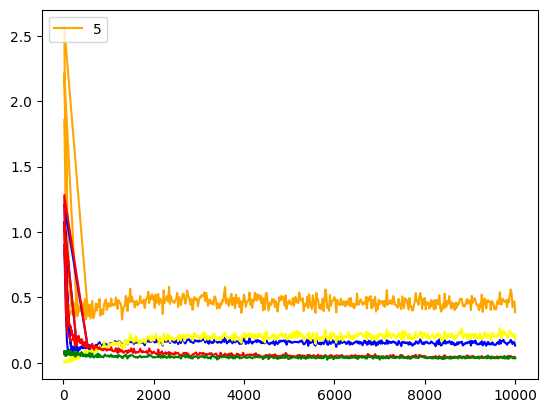

In [14]:
# Taken from https://eidos-ai.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
# https://gist.github.com/ortegatron/c0dad15e49c2b74de8bb09a5615d9f6b
import matplotlib.pyplot as plt 

resolution = "030"

for b in [5]:
    experiment_folder = f"/workspace/output/output_{resolution}_{b}/"

    def load_json_arr(json_path):
        lines = []
        with open(json_path, 'r') as f:
            for line in f:
                lines.append(json.loads(line))
        return lines

    experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

    plt.plot(
        [x['iteration'] for x in experiment_metrics if "total_loss" in x], 
        [x['total_loss'] for x in experiment_metrics if "total_loss" in x], label =b, color='orange')
    plt.plot(
        [x['iteration'] for x in experiment_metrics if 'loss_cls' in x], 
        [x['loss_cls'] for x in experiment_metrics if 'loss_cls' in x], color='blue')
    plt.plot(
        [x['iteration'] for x in experiment_metrics if 'loss_box_reg' in x], 
        [x['loss_box_reg'] for x in experiment_metrics if 'loss_box_reg' in x], color='yellow')
    plt.plot(
        [x['iteration'] for x in experiment_metrics if 'loss_rpn_cls' in x], 
        [x['loss_rpn_cls'] for x in experiment_metrics if 'loss_rpn_cls' in x], color='red')
    plt.plot(
        [x['iteration'] for x in experiment_metrics if 'loss_rpn_loc' in x], 
        [x['loss_rpn_loc'] for x in experiment_metrics if 'loss_rpn_loc' in x], color='green')
    
    plt.legend(loc='upper left')
plt.show()

In [57]:
[x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
[x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x]

[0.43310807257683626, 0.3819320087181627, 0.5013077809493244]

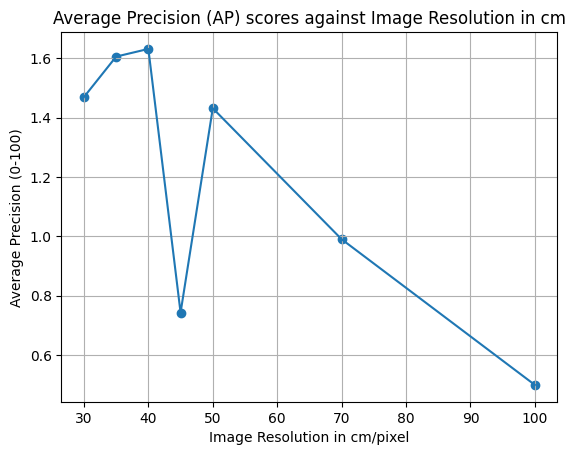

In [32]:
import matplotlib.pyplot as plt 

APs = [list(i.items())[0][1]["AP"] for i in eval_objs]
RES = [int(r) for r in resolution_set]

plt.scatter(RES, APs)
plt.plot(RES, APs)
plt.grid()
plt.title("Average Precision (AP) scores against Image Resolution in cm")
plt.xlabel("Image Resolution in cm/pixel")
plt.ylabel("Average Precision (0-100)")
plt.show()

plt.savefig('../figures/mastergraph.png')

## Visualise

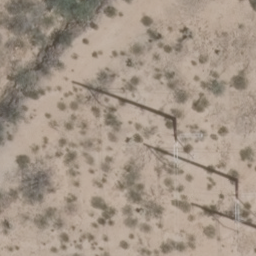

In [25]:
im = cv2.imread("/content/drive/MyDrive/hertie_master_projects/raw_data/duke/arizona/val/AR_93861085887.png")
cv2_imshow(im)

In [24]:
import cv2

In [24]:
base_path = '/workspace/data_unsplit'

In [25]:
print(base_path)

/workspace/data_unsplit


In [26]:
from detectron2.utils.visualizer import ColorMode

val_or_train = "train" # write a string here (either "val" or "train")
location = ""
dataset_dicts = json.load(open(f'{base_path}/labels_{val_or_train}.json'))

for d in random.sample(dataset_dicts['images'], 3):  
    im = cv2.imread(f'{base_path}/data_030/{val_or_train}/data/{d["file_name"]}')

    outputs = predictor_obj(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata= MetadataCatalog.get("tower_val1"), 
                   scale=0.5 
                   #,instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imshow(out.get_image()[:, :, ::-1])

NameError: name 'predictor_obj' is not defined

In [17]:
eval_objs

[OrderedDict([('bbox',
               {'AP': 4.555475653401846,
                'AP50': 16.01781471626074,
                'AP75': 0.8046226607473724,
                'APs': 4.631916954794641,
                'APm': nan,
                'APl': nan})]),
 OrderedDict([('bbox',
               {'AP': 0.4484778916175754,
                'AP50': 1.525254100963824,
                'AP75': 0.044846298725417975,
                'APs': 0.4498829985548648,
                'APm': nan,
                'APl': nan})]),
 OrderedDict([('bbox',
               {'AP': 0.015511580830218188,
                'AP50': 0.07254348623268124,
                'AP75': 0.005025883298989797,
                'APs': 0.017915768894641148,
                'APm': nan,
                'APl': nan})])]

In [ ]:
import matplotlib.pyplot as plt

plt.plot(eval_obs[])